<a href="https://colab.research.google.com/github/LavaKumarVS/Model_Train_-_Test_for_MRI_kaggle_dataset_ResNet50/blob/main/Model_Train_%26_Test_for_MRI_kaggle_dataset_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/kaggle_3m

/content/drive/MyDrive/kaggle_3m


In [ ]:
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df['mask'].value_counts() #Slighty imbalance dataset, but enough to train!

,count
mask,
0,2556
1,1373


In [ ]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

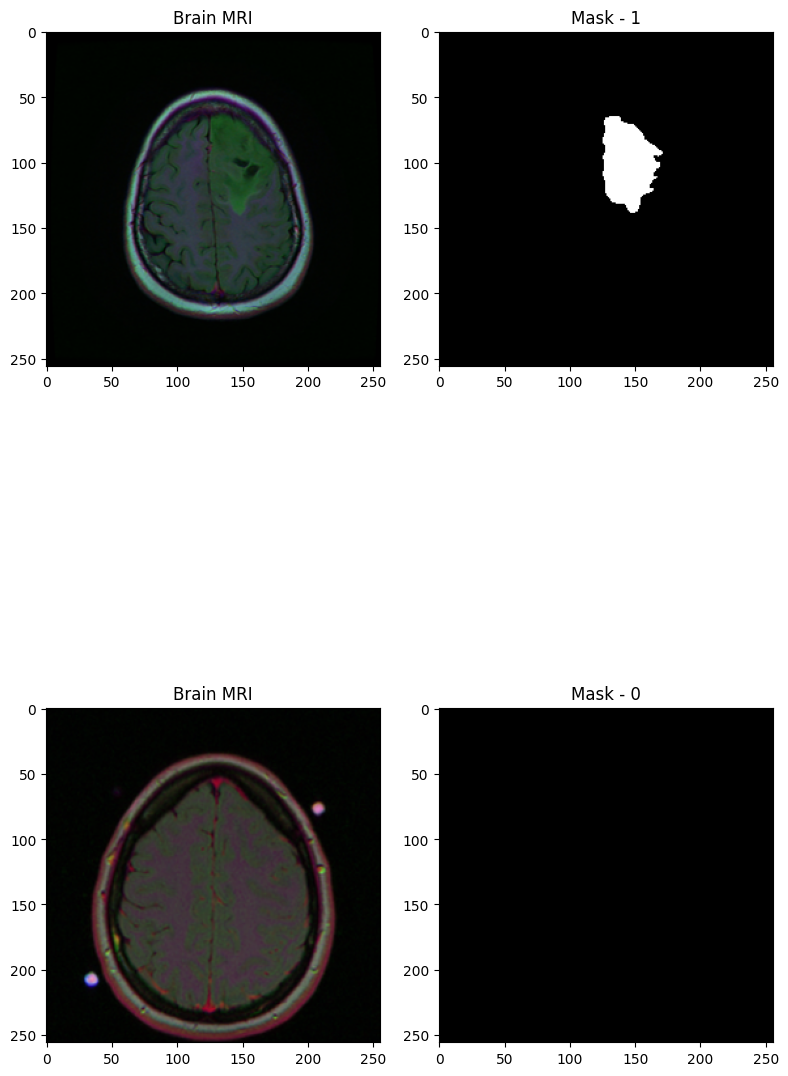

In [ ]:
import random # random selection of 6 already avaible brain and segemeted image, just checking drive dataset mount upload is correct.
fig, axs = plt.subplots(2,2, figsize=(8,16))
count = 0
for x in range(2):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1

fig.tight_layout()

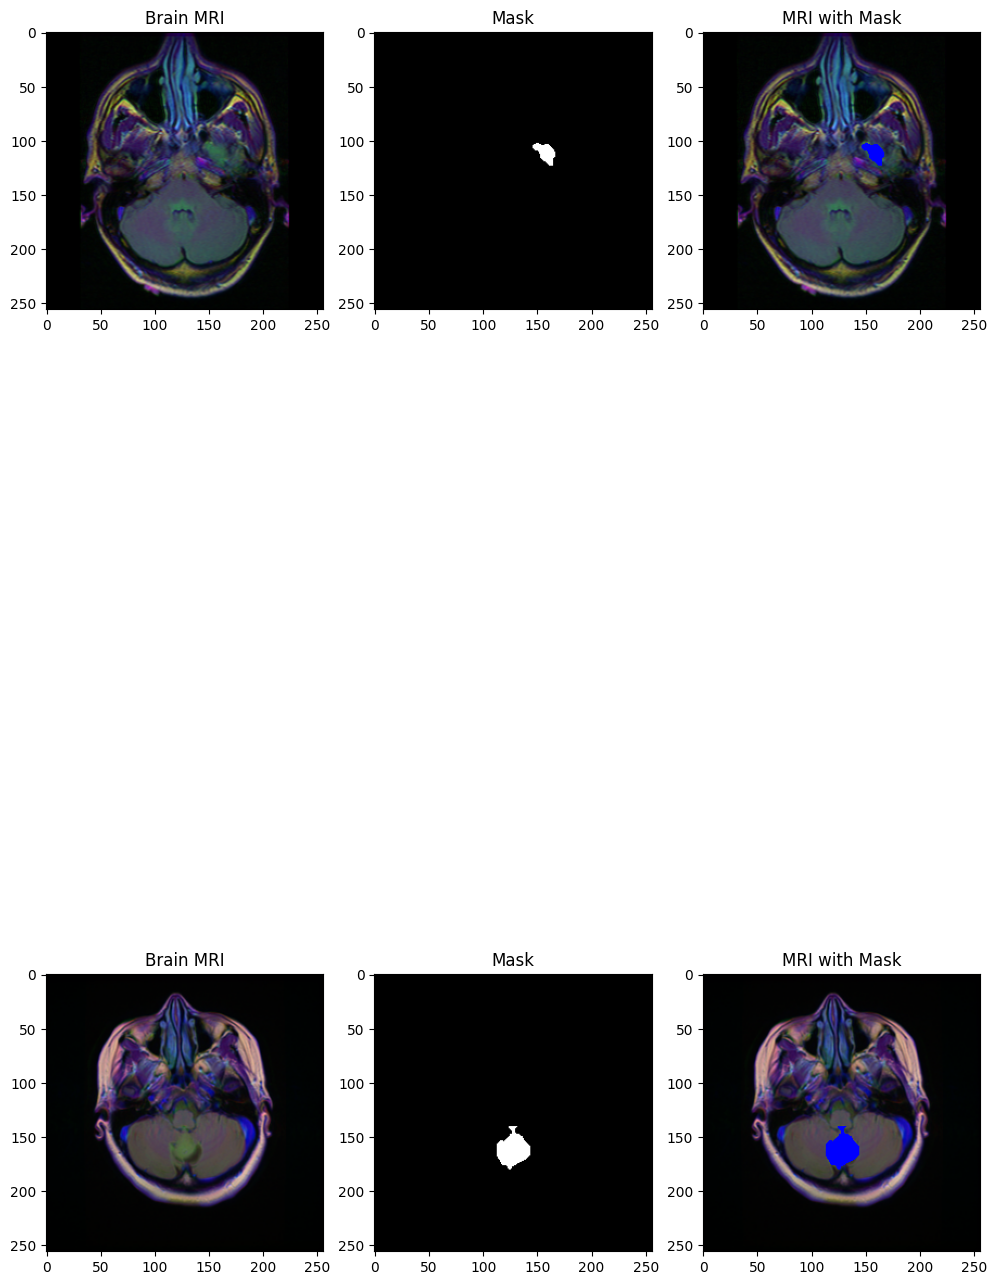

In [ ]:
count = 0 # Avaible brain image, segemeted image, Brian with segmented part coloured blue with RGB (0,0,255)
fig, axs = plt.subplots(2,3, figsize=(10,25))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 2:

    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')




    img[mask == 255] = (0,0,255)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [ ]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x)) # converting mask colum boolean into string aslo starting with binary calssifiction of supervised learning.

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split # split of test & train.

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
from keras_preprocessing.image import ImageDataGenerator # image generator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


Found 500 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))


Found 590 validated image filenames belonging to 2 classes.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3))) #ResNet50 with weights train & Test on imagenet

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
for layer in basemodel.layers: # frezzing the model
  layers.trainable = False

In [ ]:
headmodel = basemodel.output # adding headmodel classifier
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# saving model with least validation loss.
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/kaggle_3m/weights.keras", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))



 21/177 ━━━━━━━━━━━━━━━━━━━━ 52:59 20s/step - accuracy: 0.6585 - loss: 1.6059

KeyboardInterrupt: 

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
import tensorflow as tf
import json

# JSON model
with open("resnet-50-MRI.json", "r") as json_file:
    json_savedModel = json_file.read()

# model with custom_objects
model = tf.keras.models.model_from_json(json_savedModel, custom_objects={"Model": tf.keras.Model})

#  weights
model.load_weights("weights.hdf5")  # Make sure this file exists


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 271s 7s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[6.3197127e-05, 9.9993676e-01],
       [2.2860131e-01, 7.7139872e-01],
       [7.5072523e-14, 9.9999994e-01],
       ...,
       [9.9999470e-01, 5.2839050e-06],
       [2.4200985e-03, 9.9757981e-01],
       [9.9999994e-01, 6.6214235e-11]], dtype=float32)

In [ ]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)


predict


array(['1', '1', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1',
       '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1',
       '0', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1',
       '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1',
       '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1',
       '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1',
       '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1',
       '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '1', '1',
       '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0

In [ ]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9826388888888888

<Axes: >

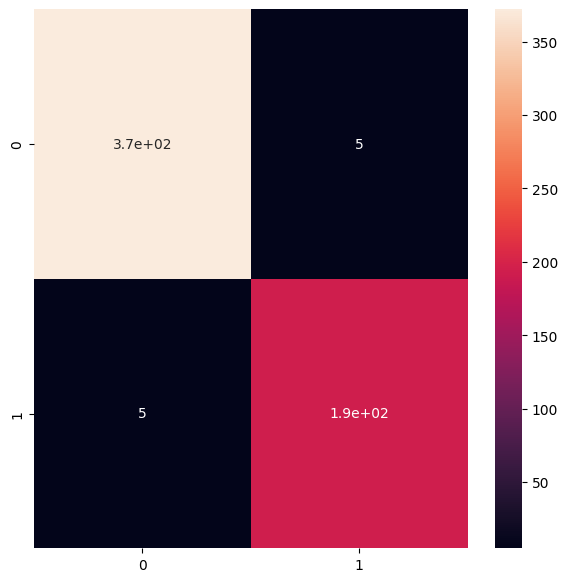

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       377
           1       0.97      0.97      0.97       199

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1] # segment model
brain_df_mask.shape

(1373, 4)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)


In [ ]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)


In [ ]:
from utilities import DataGenerator

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):



  X_copy = X



  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)



  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)



  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X


In [ ]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge


In [ ]:
input_shape = (256,256,3)


X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.keras", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.

In [ ]:
import tensorflow as tf
from utilities import focal_tversky, tversky_loss, tversky  # Ensure these functions are correctly imported


with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

#  model with custom_objects
model_seg = tf.keras.models.model_from_json(
    json_savedModel,
    custom_objects={
        "Model": tf.keras.Model,
        "focal_tversky": focal_tversky,
        "tversky_loss": tversky_loss,
        "tversky": tversky
    }
)


model_seg.load_weights('weights_seg.hdf5')

#  optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)


model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])


In [ ]:
from utilities import prediction

# prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275

In [ ]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22...,"[[[[7.794285e-07], [3.203097e-06], [8.0857835e...",1
1,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_19...,"[[[[8.1936196e-07], [3.6814668e-06], [1.070921...",1
2,TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19...,"[[[[8.270461e-07], [4.7495405e-06], [3.9805345...",1
3,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_27...,"[[[[7.50824e-07], [2.5796473e-06], [4.716437e-...",1
4,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_36...,No mask,0
...,...,...,...
585,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_30...,"[[[[7.6122785e-07], [3.1069267e-06], [7.979808...",1
586,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_7.tif,No mask,0
587,TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14...,No mask,0
588,TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_31...,"[[[[2.3135019e-07], [6.193954e-07], [1.5865933...",1


In [ ]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22...,TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22...,1,"[[[[7.794285e-07], [3.203097e-06], [8.0857835e...",1
1,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_19...,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_19...,1,"[[[[8.1936196e-07], [3.6814668e-06], [1.070921...",1
2,TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19...,TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19...,1,"[[[[8.270461e-07], [4.7495405e-06], [3.9805345...",1
3,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_27...,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_27...,1,"[[[[7.50824e-07], [2.5796473e-06], [4.716437e-...",1
4,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_36...,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_36...,0,No mask,0


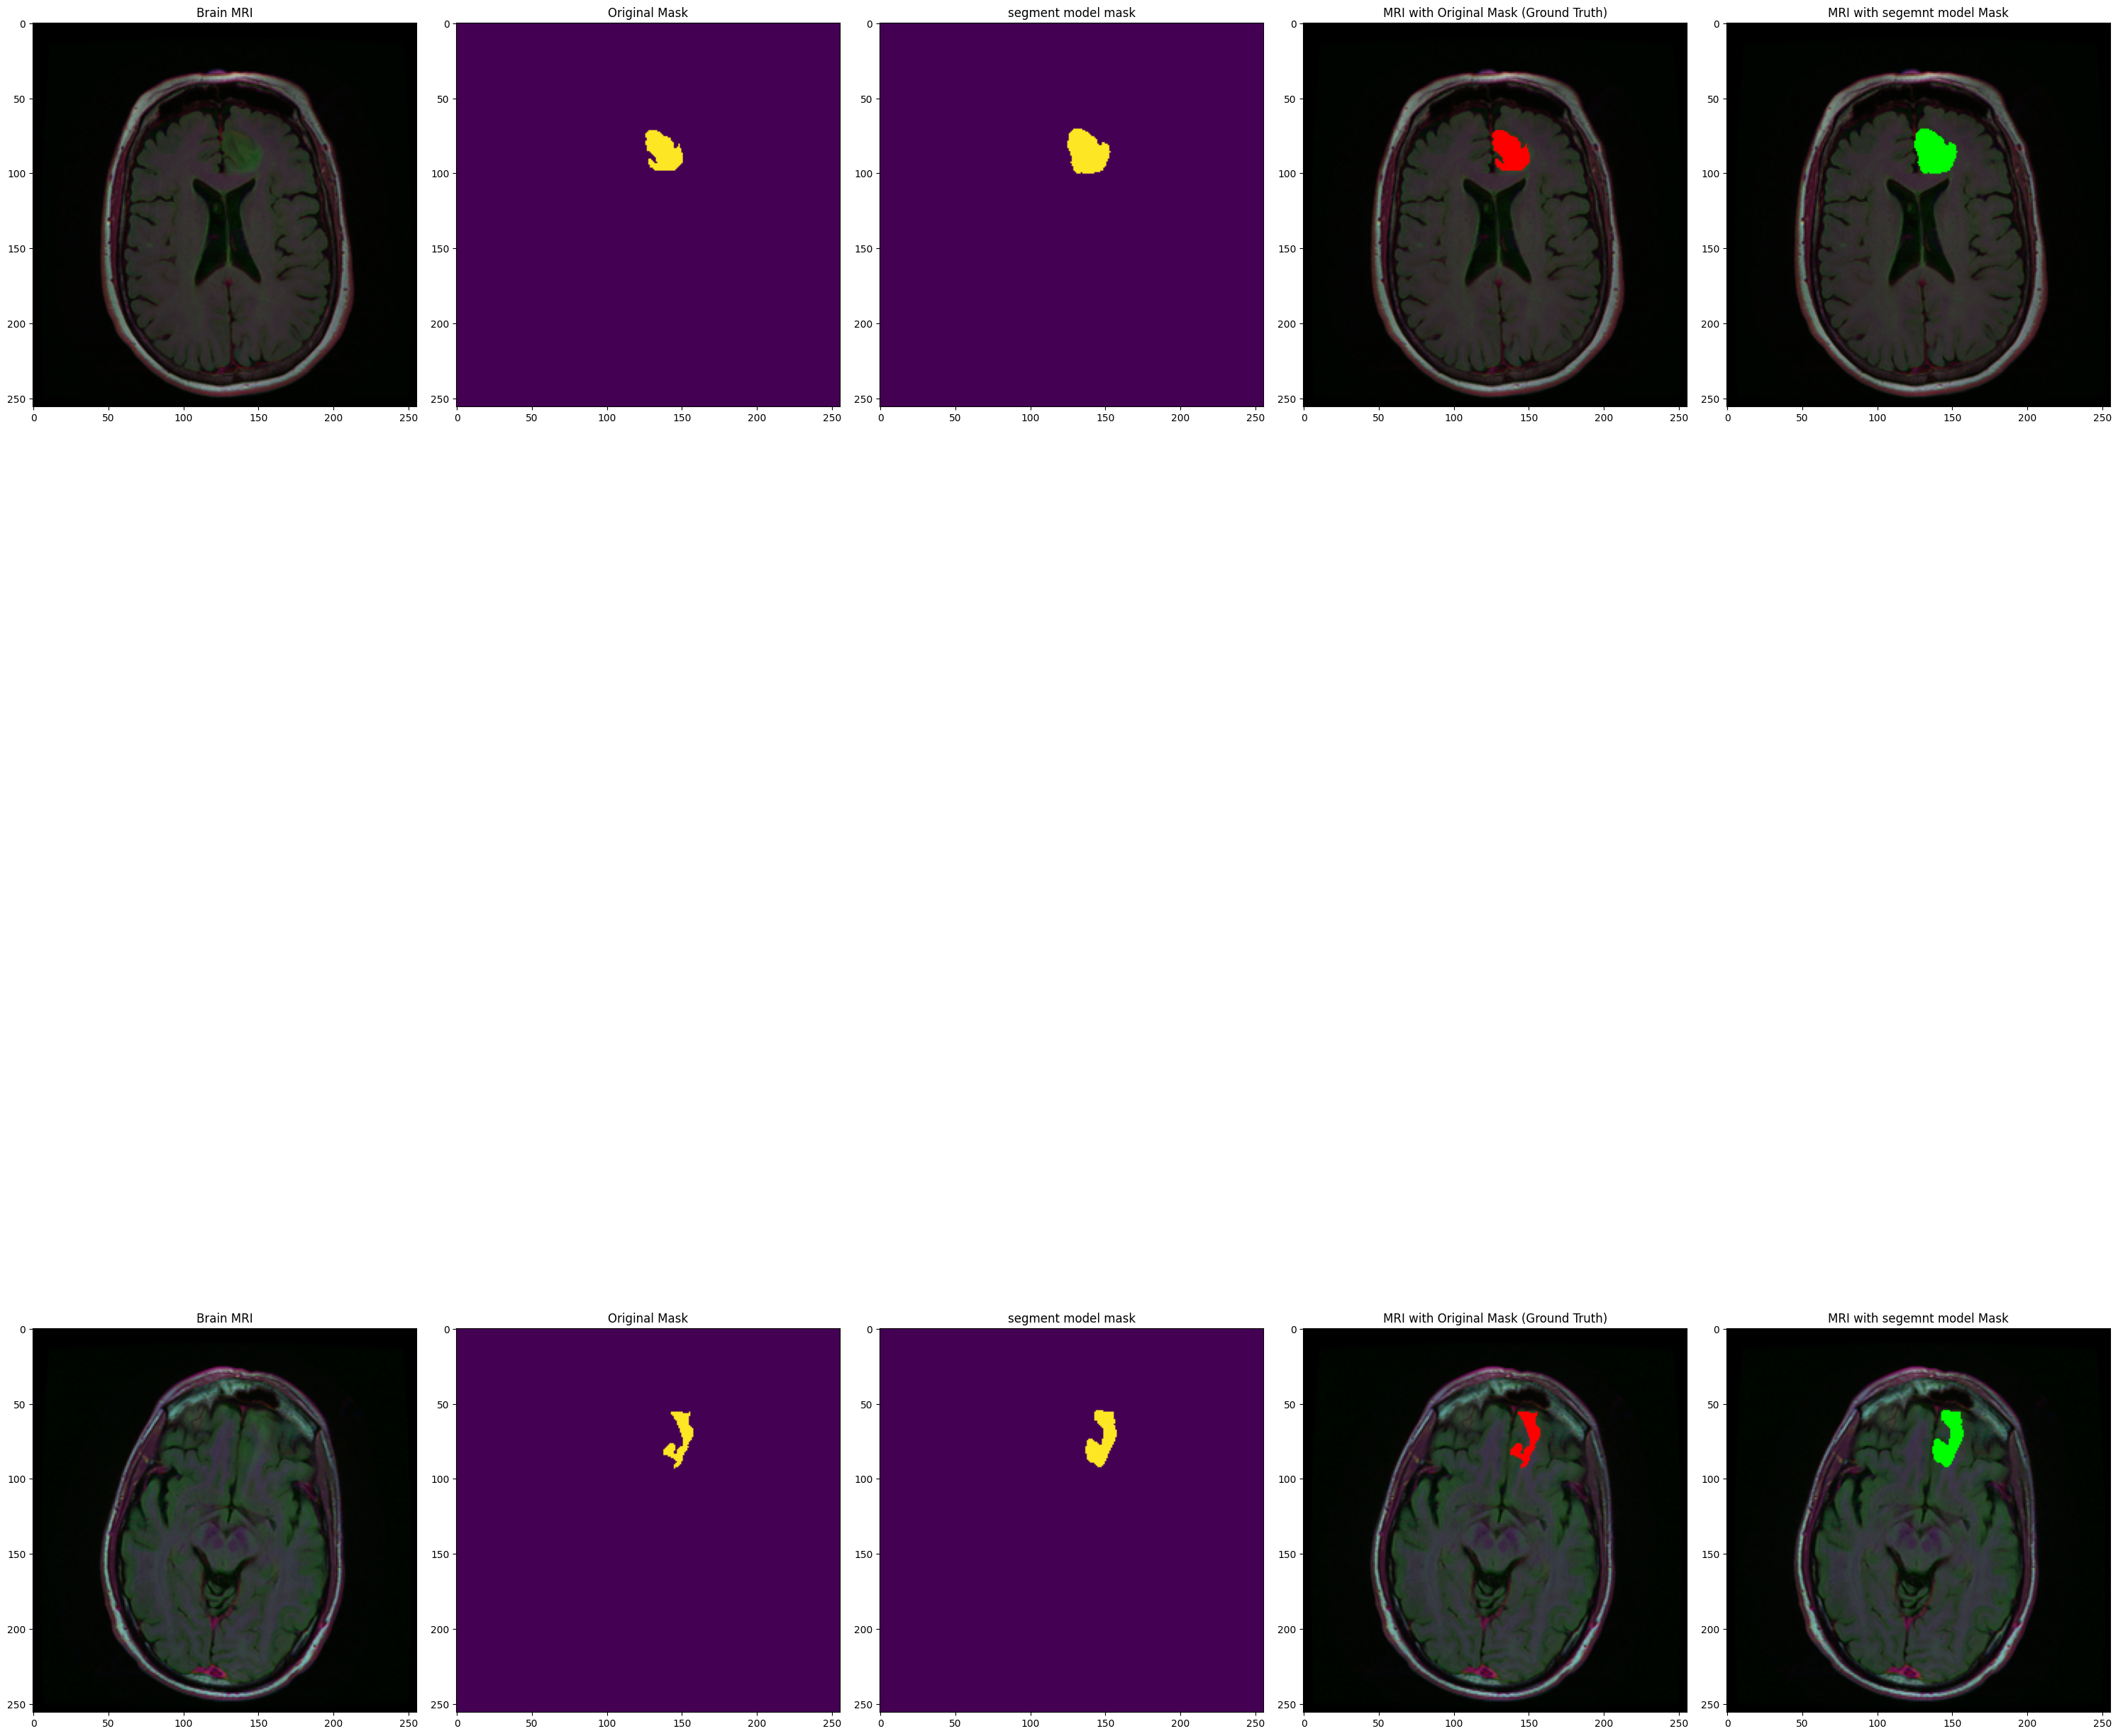

In [ ]:
count = 0
fig, axs = plt.subplots(2, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 2:

    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)


    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("segment model mask")
    axs[count][2].imshow(predicted_mask)

    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with segemnt model Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()
